In [34]:
import h5py
import operator
import os
from collections import defaultdict
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

from genomic_utils.variant import Variant

In [46]:
ENFORMER_PREDS_DIR = "/data/yosef3/scratch/ruchir/data/enformer_hg19_predictions"

In [47]:
def load_enformer_scores_for_chrom(
    chrom: str, variants: set[str], track_idx: int = 5110
) -> tuple[dict, dict]:
    sad_scores = {}
    sar_scores = {}
    h5_path = os.path.join(ENFORMER_PREDS_DIR, f"1000G.MAF_threshold=0.005.{chrom}.h5")

    with h5py.File(h5_path, "r") as f:
        chr_ = f["chr"][:].astype(str)
        pos = f["pos"][:].astype(int)
        ref = f["ref"][:].astype(str)
        alt = f["alt"][:].astype(str)
        sad = f["SAD"][:, track_idx]
        sar = f["SAR"][:, track_idx]

        for i in range(len(chr_)):
            v_original = str(Variant(chr_[i], pos[i], ref[i], alt[i]))
            v_flipped = str(Variant(chr_[i], pos[i], alt[i], ref[i]))
            if v_original in variants:
                sad_scores[v_original] = sad[i]
                sar_scores[v_original] = sar[i]
            elif v_flipped in variants:
                sad_scores[v_flipped] = -1.0 * sad[i]
                sar_scores[v_flipped] = -1.0 * sar[i]

    return sad_scores, sar_scores

In [66]:
my_scores_df = pd.read_csv("ism_scores/znf83.csv", index_col=0)
my_scores_df["ref"] = (my_scores_df["ref_wo_rc"] + my_scores_df["ref_rc"]) / 2
my_scores_df["alt"] = (my_scores_df["alt_wo_rc"] + my_scores_df["alt_rc"]) / 2
my_scores_df["SAR"] = np.log2(1 + my_scores_df["alt"]) - np.log2(
    1 + my_scores_df["ref"]
)
my_scores_df

,ref_wo_rc,ref_rc,alt_wo_rc,alt_rc,ISM_wo_rc,ISM_rc,ISM,ref,alt,SAR
chr19:53169321 G/A,0.597061,0.774816,0.595835,0.774256,-0.001226,-0.000560,-0.000893,0.685939,0.685046,-0.000764
chr19:53169330 T/C,0.555750,0.747766,0.549484,0.747240,-0.006266,-0.000526,-0.003396,0.651758,0.648362,-0.002969
chr19:53169342 G/A,0.502186,0.746477,0.501934,0.745259,-0.000252,-0.001218,-0.000735,0.624332,0.623597,-0.000653
chr19:53169348 C/T,0.513228,0.812837,0.512545,0.813251,-0.000684,0.000414,-0.000135,0.663033,0.662898,-0.000117
chr19:53169353 C/G,0.565738,0.783082,0.566984,0.781883,0.001246,-0.001199,0.000023,0.674410,0.674433,0.000020
...,...,...,...,...,...,...,...,...,...,...
chr19:53218154 G/A,0.397705,0.622263,0.397641,0.622075,-0.000064,-0.000188,-0.000126,0.509984,0.509858,-0.000121
chr19:53218182 C/T,0.393182,0.641710,0.392723,0.641512,-0.000459,-0.000198,-0.000329,0.517446,0.517117,-0.000313
chr19:53218183 G/A,0.416304,0.625329,0.415822,0.624812,-0.000481,-0.000518,-0.000500,0.520817,0.520317,-0.000474
chr19:53218233 G/C,0.492812,0.676601,0.492973,0.676393,0.000161,-0.000208,-0.000024,0.584706,0.584683,-0.000022


In [52]:
enformer_sad_scores, enformer_sar_scores = load_enformer_scores_for_chrom(
    "19", set(my_scores_df.index)
)

In [55]:
joint_scores_df = my_scores_df.copy()
joint_scores_df["Enformer_SAD"] = joint_scores_df.index.map(enformer_sad_scores)
joint_scores_df["Enformer_SAR"] = joint_scores_df.index.map(enformer_sar_scores)

In [58]:
def spearmanr_nan(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    return spearmanr(a[mask], b[mask])


def pearsonr_nan(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    return pearsonr(a[mask], b[mask])


def sign_agreemment_nan(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    return np.mean(np.sign(a[mask]) == np.sign(b[mask]))

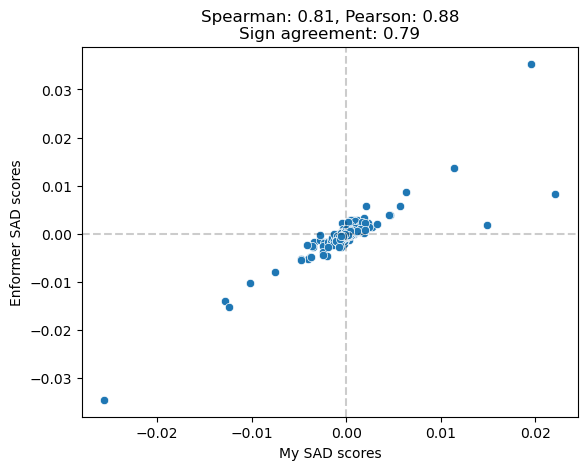

In [61]:
spearman = spearmanr_nan(joint_scores_df["ISM"], joint_scores_df["Enformer_SAD"])[0]
pearson = pearsonr_nan(joint_scores_df["ISM"], joint_scores_df["Enformer_SAD"])[0]
sign_agreement = sign_agreemment_nan(
    joint_scores_df["ISM"], joint_scores_df["Enformer_SAD"]
)

fig, ax = plt.subplots()
sns.scatterplot(data=joint_scores_df, x="ISM", y="Enformer_SAD", ax=ax)
ax.axhline(0, color="black", linestyle="--", alpha=0.2)
ax.axvline(0, color="black", linestyle="--", alpha=0.2)
ax.set_xlabel("My SAD scores")
ax.set_ylabel("Enformer SAD scores")
ax.set_title(
    f"Spearman: {spearman:.2f}, Pearson: {pearson:.2f}"
    + "\n"
    + f"Sign agreement: {sign_agreement:.2f}"
)
plt.show()

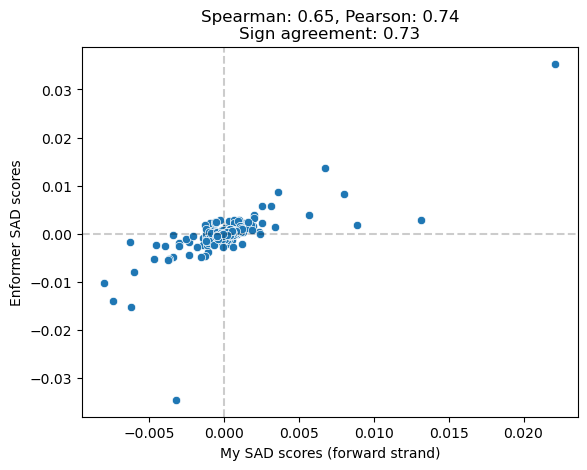

In [67]:
spearman = spearmanr_nan(joint_scores_df["ISM_wo_rc"], joint_scores_df["Enformer_SAD"])[
    0
]
pearson = pearsonr_nan(joint_scores_df["ISM_wo_rc"], joint_scores_df["Enformer_SAD"])[0]
sign_agreement = sign_agreemment_nan(
    joint_scores_df["ISM_wo_rc"], joint_scores_df["Enformer_SAD"]
)

fig, ax = plt.subplots()
sns.scatterplot(data=joint_scores_df, x="ISM_wo_rc", y="Enformer_SAD", ax=ax)
ax.axhline(0, color="black", linestyle="--", alpha=0.2)
ax.axvline(0, color="black", linestyle="--", alpha=0.2)
ax.set_xlabel("My SAD scores (forward strand)")
ax.set_ylabel("Enformer SAD scores")
ax.set_title(
    f"Spearman: {spearman:.2f}, Pearson: {pearson:.2f}"
    + "\n"
    + f"Sign agreement: {sign_agreement:.2f}"
)
plt.show()

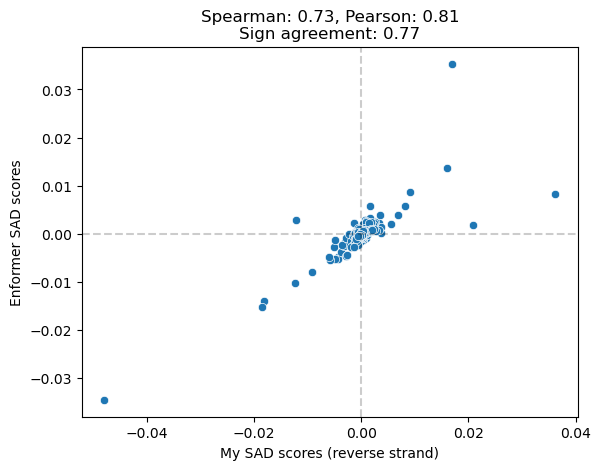

In [68]:
spearman = spearmanr_nan(joint_scores_df["ISM_rc"], joint_scores_df["Enformer_SAD"])[0]
pearson = pearsonr_nan(joint_scores_df["ISM_rc"], joint_scores_df["Enformer_SAD"])[0]
sign_agreement = sign_agreemment_nan(
    joint_scores_df["ISM_rc"], joint_scores_df["Enformer_SAD"]
)

fig, ax = plt.subplots()
sns.scatterplot(data=joint_scores_df, x="ISM_rc", y="Enformer_SAD", ax=ax)
ax.axhline(0, color="black", linestyle="--", alpha=0.2)
ax.axvline(0, color="black", linestyle="--", alpha=0.2)
ax.set_xlabel("My SAD scores (reverse strand)")
ax.set_ylabel("Enformer SAD scores")
ax.set_title(
    f"Spearman: {spearman:.2f}, Pearson: {pearson:.2f}"
    + "\n"
    + f"Sign agreement: {sign_agreement:.2f}"
)
plt.show()

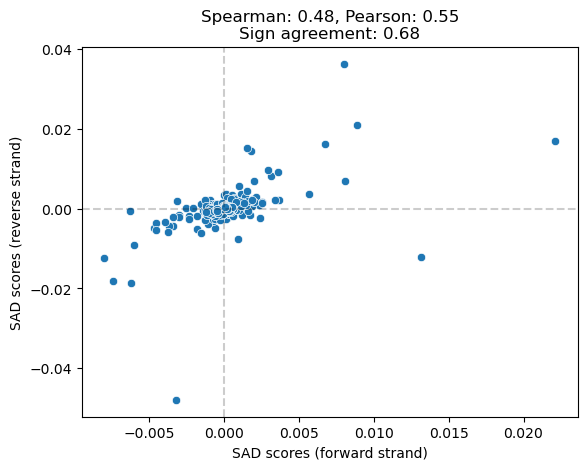

In [65]:
spearman = spearmanr_nan(joint_scores_df["ISM_wo_rc"], joint_scores_df["ISM_rc"])[0]
pearson = pearsonr_nan(joint_scores_df["ISM_wo_rc"], joint_scores_df["ISM_rc"])[0]
sign_agreement = sign_agreemment_nan(
    joint_scores_df["ISM_wo_rc"], joint_scores_df["ISM_rc"]
)

fig, ax = plt.subplots()
sns.scatterplot(data=joint_scores_df, x="ISM_wo_rc", y="ISM_rc", ax=ax)
ax.axhline(0, color="black", linestyle="--", alpha=0.2)
ax.axvline(0, color="black", linestyle="--", alpha=0.2)
ax.set_xlabel("SAD scores (forward strand)")
ax.set_ylabel("SAD scores (reverse strand)")
ax.set_title(
    f"Spearman: {spearman:.2f}, Pearson: {pearson:.2f}"
    + "\n"
    + f"Sign agreement: {sign_agreement:.2f}"
)
plt.show()

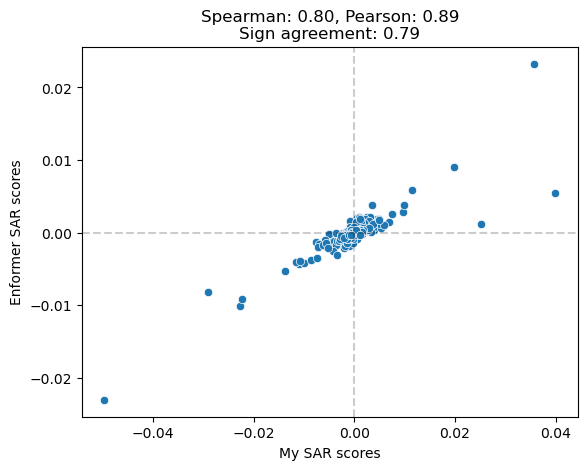

In [45]:
my_sar_scores_l = [my_sar_scores[v] for v in shared_variants]
enformer_sar_scores_l = [enformer_sar_scores[v] for v in shared_variants]
spearman, _ = spearmanr(my_sar_scores_l, enformer_sar_scores_l)
pearson, _ = pearsonr(my_sar_scores_l, enformer_sar_scores_l)
sign_agreement = np.mean(np.sign(my_sar_scores_l) == np.sign(enformer_sar_scores_l))

fig, ax = plt.subplots()
sns.scatterplot(x=my_sar_scores_l, y=enformer_sar_scores_l, ax=ax)
ax.axhline(0, color="black", linestyle="--", alpha=0.2)
ax.axvline(0, color="black", linestyle="--", alpha=0.2)
ax.set_xlabel("My SAR scores")
ax.set_ylabel("Enformer SAR scores")
ax.set_title(
    f"Spearman: {spearman:.2f}, Pearson: {pearson:.2f}"
    + "\n"
    + f"Sign agreement: {sign_agreement:.2f}"
)
plt.show()